 ## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import copy

## Data Setup

In [ ]:
from google.colab import files
uploaded = files.upload() #Grab the steam spy detailed file when you need to choose a file, it will take a minute to upload

Saving steam_spy_detailed.json to steam_spy_detailed.json


In [ ]:
steamspy = pd.read_json('steam_spy_detailed.json')

In [ ]:
steamspy.head() #Data currently has IDs as columns and features as rows

,570,730,578080,1063730,440,304930,271590,550,230410,105600,...,852,18310,497960,512720,848400,1406980,1209610,1503000,1506770,1894760
appid,570,730,578080,1063730,440,304930,271590,550,230410,105600,...,852,18310,497960,512720,848400,1406980,1209610,1503000,1506770,1894760
name,Dota 2,Counter-Strike: Global Offensive,PUBG: BATTLEGROUNDS,New World,Team Fortress 2,Unturned,Grand Theft Auto V,Left 4 Dead 2,Warframe,Terraria,...,ValveTestApp852,Spectraball - Demo,Legends of Callasia Demo,Velocidevorium,Simian Rising,Road Tripper,Virtually Real Life,The Chaos Gene,Crawler,SnakeGame
developer,Valve,"Valve, Hidden Path Entertainment","KRAFTON, Inc.",Amazon Games,Valve,Smartly Dressed Games,Rockstar North,Valve,Digital Extremes,Re-Logic,...,,,,Really Slick,All Caps Industries,Big Bird Games,Freedom Software,Andrew T Productions,MZY GAMES,galesoozka
publisher,Valve,Valve,"KRAFTON, Inc.",Amazon Games,Valve,Smartly Dressed Games,Rockstar Games,Valve,Digital Extremes,Re-Logic,...,,,,Really Slick,All Caps Industries,Big Bird Games,Freedom Software,Andrew T Productions,MZY GAMES,galesoozka
score_rank,,,,,,,,,,,...,,,,,,,,,,


In [ ]:
steamspy = steamspy.transpose()
steamspy.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
570,570,Dota 2,Valve,Valve,,1457539,292073,0,"100,000,000 .. 200,000,000",36947,1714,971,873,0,0,0,597406,"English, Bulgarian, Czech, Danish, Dutch, Finn...","Action, Free to Play, Strategy","{'Free to Play': 58393, 'MOBA': 19421, 'Multip..."
730,730,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,,5683636,757108,0,"50,000,000 .. 100,000,000",28757,862,6475,361,0,0,0,820998,"English, Czech, Danish, Dutch, Finnish, French...","Action, Free to Play","{'FPS': 87642, 'Shooter': 62951, 'Multiplayer'..."
578080,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",,1140088,888932,0,"50,000,000 .. 100,000,000",22351,808,7452,167,0,0,0,363124,"English, Korean, Simplified Chinese, French, G...","Action, Adventure, Free to Play, Massively Mul...","{'Survival': 13969, 'Shooter': 11785, 'Multipl..."
1063730,1063730,New World,Amazon Games,Amazon Games,,153855,73173,0,"50,000,000 .. 100,000,000",6166,227,2792,162,3999,3999,0,20317,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Massively Multiplayer, RPG","{'Massively Multiplayer': 569, 'Open World': 5..."
440,440,Team Fortress 2,Valve,Valve,,813449,56122,0,"50,000,000 .. 100,000,000",11986,1677,326,468,0,0,0,80497,"English, Danish, Dutch, Finnish, French, Germa...","Action, Free to Play","{'Free to Play': 61461, 'Hero Shooter': 60534,..."


# Preproccessing, What to do:
 Deal with nulls

 Drop app id, name, userscore, average and median players, current price, concurrent players, and discount
 
 Convert owners range into an int:
    The owners range is innacurate for low owner scores so we are going to making an estimate on the # of owners from reviews.
    
    Generally, you can estimate the sales of a game from between 30x-70x the amount of reviews as per Article 4 on the proposal.
    
    We will generalize this to 50x the amount of total reviews as an estimated amount of owners
    
    Then we convert this to a label column based on if the owners value is >= 100000 *
        
 Convert pos/neg reviews into a ratio of positive to total
 
     May want to attempt using this as the labels instead of owners if the accuracy of owners is poor *
 
 Find average review score of a dev and publisher, replace name with that score
  
 Find top 8 count of genres to make into columns *
 
 Find top 5 count of tags to make into columns *
 
 Find top 5 languages to make into columns *
     
 Turn languages into int # of languages *
 
     May want to remove this int if it is too highly corelated to the categorical language columns
  
 Create a categorical column if a game is free or not*

     May want to account for different prices of games that are not free
     
         Issue is linearity with the free to play feature

## Data Analysis

In [ ]:
steamspy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52036 entries, 570 to 1894760
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   appid            52036 non-null  object
 1   name             52036 non-null  object
 2   developer        52036 non-null  object
 3   publisher        52036 non-null  object
 4   score_rank       52036 non-null  object
 5   positive         52036 non-null  object
 6   negative         52036 non-null  object
 7   userscore        52036 non-null  object
 8   owners           52036 non-null  object
 9   average_forever  52036 non-null  object
 10  average_2weeks   52036 non-null  object
 11  median_forever   52036 non-null  object
 12  median_2weeks    52036 non-null  object
 13  price            52007 non-null  object
 14  initialprice     52014 non-null  object
 15  discount         52014 non-null  object
 16  ccu              52036 non-null  object
 17  languages        52014 non-

In [ ]:
steamspy[steamspy['owners'] == '50,000 .. 100,000'].head(5) #We can see the amount of reviews is wildly different, high chance that the range is inaccurate for this low of values

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
331360,331360,Heavy Metal Machines,Hoplon,Hoplon,,2910,987,0,"50,000 .. 100,000",218,0,29,0,0,0,0,11,"English, Portuguese - Brazil, Russian, French,...","Action, Casual, Free to Play, Indie, Sports","{'Free to Play': 346, 'Vehicular Combat': 335,..."
266210,266210,One Way Heroics,Smoking WOLF,PLAYISM,,3654,223,0,"50,000 .. 100,000",241,0,172,0,349,349,0,18,"English, Japanese","Indie, RPG","{'Side Scroller': 568, 'Traditional Roguelike'..."
351940,351940,The Descendant,Gaming Corps AB,"Microids Indie, Microids",,4796,673,0,"50,000 .. 100,000",907,0,250,0,1499,1499,0,341,"English, French, Italian, German, Spanish - Spain","Adventure, Casual, Indie","{'Adventure': 8422, 'Point & Click': 110, 'Cas..."
410990,410990,Master of Orion 3,Quicksilver Software,Wargaming Labs,,59,65,0,"50,000 .. 100,000",0,0,0,0,999,999,0,16,English,Strategy,"{'Strategy': 52, '4X': 36, 'Space': 14, 'Turn-..."
1399760,1399760,Randomlands,Atahan Öztürk,Atahan Öztürk,,3,3,0,"50,000 .. 100,000",0,0,0,0,99,99,0,0,"English, Turkish","Action, Indie","{'Action': 252, 'Shooter': 226, 'FPS': 223, 'L..."


In [ ]:
steamspy['owners'].value_counts()

0 .. 20,000                   35687
20,000 .. 50,000               6597
50,000 .. 100,000              3431
100,000 .. 200,000             2363
200,000 .. 500,000             2090
500,000 .. 1,000,000            884
1,000,000 .. 2,000,000          498
2,000,000 .. 5,000,000          329
5,000,000 .. 10,000,000          94
10,000,000 .. 20,000,000         38
20,000,000 .. 50,000,000         20
50,000,000 .. 100,000,000         4
100,000,000 .. 200,000,000        1
Name: owners, dtype: int64

## Data Cleanup

In [ ]:
steamspy.drop(labels=['appid','name','ccu','score_rank','userscore', 'average_forever','average_2weeks','median_forever','median_2weeks','price','discount'], axis=1, inplace = True)

In [ ]:
steamspy.isnull().sum()

developer        0
publisher        0
positive         0
negative         0
owners           0
initialprice    22
languages       22
genre            0
tags             0
dtype: int64

In [ ]:
steamspy.dropna(inplace=True)

In [ ]:
steamspy.isnull().sum()

developer       0
publisher       0
positive        0
negative        0
owners          0
initialprice    0
languages       0
genre           0
tags            0
dtype: int64

## Transforming Reviews

In [ ]:
steamspy['positive'] = pd.to_numeric(steamspy['positive'])
steamspy['negative'] = pd.to_numeric(steamspy['negative'])
steamspy.dtypes

developer       object
publisher       object
positive         int64
negative         int64
owners          object
initialprice    object
languages       object
genre           object
tags            object
dtype: object

In [ ]:
steamspy[(steamspy['negative'] == 0) & (steamspy['positive'] == 0)]

,developer,publisher,positive,negative,owners,initialprice,languages,genre,tags
21110,"Monolith Productions, Inc., Timegate","Warner Bros. Games, Warner Bros. Interactive E...",0,0,"1,000,000 .. 2,000,000",5499,English,Action,[]
21120,"Monolith Productions, Inc., Timegate","Warner Bros. Games, Warner Bros. Interactive E...",0,0,"1,000,000 .. 2,000,000",5499,English,Action,[]
1294340,BUSAN SANAI GAMES,Super.com,0,0,"200,000 .. 500,000",1599,"English, French, German, Spanish - Spain, Port...","Action, Adventure, Indie, Strategy","{'Strategy': 589, 'Real Time Tactics': 414, 'D..."
1948280,Sokpop Collective,Sokpop Collective,0,0,"100,000 .. 200,000",499,"English, French, Italian, German, Spanish - Sp...","Casual, Indie, Simulation","{'Rogue-lite': 162, 'Card Battler': 159, 'Soli..."
8640,SimBin,SimBin,0,0,"100,000 .. 200,000",799,"English, French, German, Italian, Spanish - Spain",Racing,[]
...,...,...,...,...,...,...,...,...,...
706550,KirUn,KirUn,0,0,"0 .. 20,000",0,"English, French, Italian, German, Spanish - Sp...","Indie, Strategy",[]
852,,,0,0,"0 .. 20,000",0,,,[]
18310,,,0,0,"0 .. 20,000",0,,,[]
512720,Really Slick,Really Slick,0,0,"0 .. 20,000",0,English,"Action, Casual, Indie",[]


In [ ]:
steamspy['reviewScore'] = steamspy['positive']/(steamspy['positive']+steamspy['negative'])
steamspy.head()

,developer,publisher,positive,negative,owners,initialprice,languages,genre,tags,reviewScore
570,Valve,Valve,1457539,292073,"100,000,000 .. 200,000,000",0,"English, Bulgarian, Czech, Danish, Dutch, Finn...","Action, Free to Play, Strategy","{'Free to Play': 58393, 'MOBA': 19421, 'Multip...",0.833064
730,"Valve, Hidden Path Entertainment",Valve,5683636,757108,"50,000,000 .. 100,000,000",0,"English, Czech, Danish, Dutch, Finnish, French...","Action, Free to Play","{'FPS': 87642, 'Shooter': 62951, 'Multiplayer'...",0.882450
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1140088,888932,"50,000,000 .. 100,000,000",0,"English, Korean, Simplified Chinese, French, G...","Action, Adventure, Free to Play, Massively Mul...","{'Survival': 13969, 'Shooter': 11785, 'Multipl...",0.561891
1063730,Amazon Games,Amazon Games,153855,73173,"50,000,000 .. 100,000,000",3999,"English, French, Italian, German, Spanish - Sp...","Action, Adventure, Massively Multiplayer, RPG","{'Massively Multiplayer': 569, 'Open World': 5...",0.677692
440,Valve,Valve,813449,56122,"50,000,000 .. 100,000,000",0,"English, Danish, Dutch, Finnish, French, Germa...","Action, Free to Play","{'Free to Play': 61461, 'Hero Shooter': 60534,...",0.935460


## Transforming Languages

In [ ]:
languagesDict = {'English':0} 
for languageStrings in steamspy['languages']:
    if ', ' in languageStrings:  
        for languages in languageStrings.split(', '):
            if languages in languagesDict:
                languagesDict[languages] = languagesDict[languages] + 1 #
            else:
                languagesDict[languages] = 1
    else:
        if languageStrings in languagesDict:
            languagesDict[languageStrings] = languagesDict[languageStrings] + 1 #
        else:
            languagesDict[languageStrings] = 1
        

In [ ]:
print(languagesDict)

{'English': 51753, 'Bulgarian': 1187, 'Czech': 2220, 'Danish': 1625, 'Dutch': 2902, 'Finnish': 1525, 'French': 12611, 'German': 13203, 'Greek': 1356, 'Hungarian': 1817, 'Italian': 8788, 'Japanese': 9580, 'Korean': 6020, 'Norwegian': 1524, 'Polish': 5075, 'Portuguese': 3797, 'Portuguese - Brazil': 6232, 'Romanian': 1355, 'Russian': 12226, 'Simplified Chinese': 11717, 'Spanish - Spain': 11509, 'Swedish': 1941, 'Thai': 1584, 'Traditional Chinese': 5738, 'Turkish': 3373, 'Ukrainian': 1777, 'Spanish - Latin America': 2414, 'Vietnamese': 1020, 'Arabic': 1687, 'Slovakian': 2, 'Not supported': 1454, 'Spanish': 2, '': 63, 'English[b]*[/b]': 1, 'Italian \r\n\r\n[b]*[/b] ': 1, '#lang_german;': 1, 'German;': 1, '#lang_#lang_russian*#lang_full_audio': 1, '#lang_#lang_spanish*#lang_full_audio': 1, '#lang_english (full audio)': 1, '(all with full audio support)': 1, '\r\nFrench': 1, '\r\nGerman': 1, '#lang_#lang_#lang_english**#lang_full_audio*#lang_full_audio': 1}


In [ ]:
# copy of dictionary to look at in EDA
languagesDict_vis = copy.deepcopy(languagesDict)

In [ ]:
print(languagesDict_vis)

{'English': 51753, 'Bulgarian': 1187, 'Czech': 2220, 'Danish': 1625, 'Dutch': 2902, 'Finnish': 1525, 'French': 12611, 'German': 13203, 'Greek': 1356, 'Hungarian': 1817, 'Italian': 8788, 'Japanese': 9580, 'Korean': 6020, 'Norwegian': 1524, 'Polish': 5075, 'Portuguese': 3797, 'Portuguese - Brazil': 6232, 'Romanian': 1355, 'Russian': 12226, 'Simplified Chinese': 11717, 'Spanish - Spain': 11509, 'Swedish': 1941, 'Thai': 1584, 'Traditional Chinese': 5738, 'Turkish': 3373, 'Ukrainian': 1777, 'Spanish - Latin America': 2414, 'Vietnamese': 1020, 'Arabic': 1687, 'Slovakian': 2, 'Not supported': 1454, 'Spanish': 2, '': 63, 'English[b]*[/b]': 1, 'Italian \r\n\r\n[b]*[/b] ': 1, '#lang_german;': 1, 'German;': 1, '#lang_#lang_russian*#lang_full_audio': 1, '#lang_#lang_spanish*#lang_full_audio': 1, '#lang_english (full audio)': 1, '(all with full audio support)': 1, '\r\nFrench': 1, '\r\nGerman': 1, '#lang_#lang_#lang_english**#lang_full_audio*#lang_full_audio': 1}


In [ ]:
top5Languages = ['English']
for i in range(4):
    del languagesDict[max(languagesDict, key = languagesDict.get)]
    top5Languages.append(max(languagesDict, key = languagesDict.get))
print (top5Languages)

['English', 'German', 'French', 'Russian', 'Simplified Chinese']


In [ ]:
def hasEnglish(col):
    if 'English' in col:
        return 1
    return 0
def hasGerman(col):
    if 'German' in col:
        return 1
    return 0
def hasFrench(col):
    if 'French' in col:
        return 1
    return 0
def hasRussian(col):
    if 'Russian' in col:
        return 1
    return 0
def hasChinese(col):
    if 'Simplified Chinese' in col:
        return 1
    return 0

steamspy['hasEnglish'] = steamspy['languages'].apply(hasEnglish)
steamspy['hasGerman'] = steamspy['languages'].apply(hasGerman)
steamspy['hasFrench'] = steamspy['languages'].apply(hasFrench)
steamspy['hasRussian'] = steamspy['languages'].apply(hasRussian)
steamspy['hasChinese'] = steamspy['languages'].apply(hasChinese)

In [ ]:
def languagesToInt(col):
    i = 0
    if ', ' in col:
        for languages in col.split(', '):
            i = i + 1
        return i
    else:
        return 1;
steamspy['languages'] = steamspy['languages'].apply(languagesToInt)

In [ ]:
steamspy.head()

,developer,publisher,positive,negative,owners,initialprice,languages,genre,tags,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese
570,Valve,Valve,1457539,292073,"100,000,000 .. 200,000,000",0,28,"Action, Free to Play, Strategy","{'Free to Play': 58393, 'MOBA': 19421, 'Multip...",0.833064,1,1,1,1,1
730,"Valve, Hidden Path Entertainment",Valve,5683636,757108,"50,000,000 .. 100,000,000",0,28,"Action, Free to Play","{'FPS': 87642, 'Shooter': 62951, 'Multiplayer'...",0.882450,1,1,1,1,1
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1140088,888932,"50,000,000 .. 100,000,000",0,17,"Action, Adventure, Free to Play, Massively Mul...","{'Survival': 13969, 'Shooter': 11785, 'Multipl...",0.561891,1,1,1,1,1
1063730,Amazon Games,Amazon Games,153855,73173,"50,000,000 .. 100,000,000",3999,8,"Action, Adventure, Massively Multiplayer, RPG","{'Massively Multiplayer': 569, 'Open World': 5...",0.677692,1,1,1,0,0
440,Valve,Valve,813449,56122,"50,000,000 .. 100,000,000",0,26,"Action, Free to Play","{'Free to Play': 61461, 'Hero Shooter': 60534,...",0.935460,1,1,1,1,1


## Transforming Genre

In [ ]:
genreDict = {'Action':0} 
for genreStrings in steamspy['genre']:
    if ', ' in genreStrings:  
        for genres in genreStrings.split(', '):
            if genres in genreDict:
                genreDict[genres] = genreDict[genres] + 1 #
            else:
                genreDict[genres] = 1
    else:
        if genreStrings in genreDict:
            genreDict[genreStrings] = genreDict[genreStrings] + 1 #
        else:
            genreDict[genreStrings] = 1
print(genreDict)

{'Action': 22213, 'Free to Play': 3392, 'Strategy': 10069, 'Adventure': 19828, 'Massively Multiplayer': 1428, 'RPG': 8823, 'Casual': 20483, 'Indie': 36948, 'Simulation': 10110, 'Early Access': 5717, 'Animation & Modeling': 326, 'Design & Illustration': 404, 'Photo Editing': 104, 'Utilities': 670, 'Sports': 2484, 'Racing': 1985, '': 251, 'Video Production': 241, 'Gore': 65, 'Audio Production': 193, 'Software Training': 166, 'Web Publishing': 94, 'Game Development': 156, 'Violent': 111, 'Movie': 2, 'Education': 314, 'Accounting': 17, 'Sexual Content': 33, 'Nudity': 28, 'Documentary': 1, 'Episodic': 1, 'Short': 1, 'Tutorial': 1, '360 V': 1}


In [ ]:
# copy of dictionary to look at in EDA
genreDict_vis = copy.deepcopy(genreDict)

In [ ]:
top8Genres = ['Indie']
for i in range(7):
    del genreDict[max(genreDict, key = genreDict.get)]
    top8Genres.append(max(genreDict, key = genreDict.get))
print (top8Genres)

['Indie', 'Action', 'Casual', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'Early Access']


In [ ]:
def hasIndie(col):
    if 'Indie' in col:
        return 1
    return 0
def hasAction(col):
    if 'Action' in col:
        return 1
    return 0
def hasCasual(col):
    if 'Casual' in col:
        return 1
    return 0
def hasAdventure(col):
    if 'Adventure' in col:
        return 1
    return 0
def hasSimulation(col):
    if 'Simulation' in col:
        return 1
    return 0
def hasStrategy(col):
    if 'Strategy' in col:
        return 1
    return 0
def hasRPG(col):
    if 'RPG' in col:
        return 1
    return 0
def hasEA(col):
    if 'Early Access' in col:
        return 1
    return 0

steamspy['hasIndie'] = steamspy['genre'].apply(hasIndie)
steamspy['hasAction'] = steamspy['genre'].apply(hasAction)
steamspy['hasCasual'] = steamspy['genre'].apply(hasCasual)
steamspy['hasAdventure'] = steamspy['genre'].apply(hasAdventure)
steamspy['hasSimulation'] = steamspy['genre'].apply(hasSimulation)
steamspy['hasStrategy'] = steamspy['genre'].apply(hasStrategy)
steamspy['hasRPG'] = steamspy['genre'].apply(hasRPG)
steamspy['hasEA'] = steamspy['genre'].apply(hasEA)
steamspy.drop(labels = ['genre'], axis = 1, inplace=True)
steamspy.head()

,developer,publisher,positive,negative,owners,initialprice,languages,tags,reviewScore,hasEnglish,...,hasRussian,hasChinese,hasIndie,hasAction,hasCasual,hasAdventure,hasSimulation,hasStrategy,hasRPG,hasEA
570,Valve,Valve,1457539,292073,"100,000,000 .. 200,000,000",0,28,"{'Free to Play': 58393, 'MOBA': 19421, 'Multip...",0.833064,1,...,1,1,0,1,0,0,0,1,0,0
730,"Valve, Hidden Path Entertainment",Valve,5683636,757108,"50,000,000 .. 100,000,000",0,28,"{'FPS': 87642, 'Shooter': 62951, 'Multiplayer'...",0.882450,1,...,1,1,0,1,0,0,0,0,0,0
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1140088,888932,"50,000,000 .. 100,000,000",0,17,"{'Survival': 13969, 'Shooter': 11785, 'Multipl...",0.561891,1,...,1,1,0,1,0,1,0,0,0,0
1063730,Amazon Games,Amazon Games,153855,73173,"50,000,000 .. 100,000,000",3999,8,"{'Massively Multiplayer': 569, 'Open World': 5...",0.677692,1,...,0,0,0,1,0,1,0,0,1,0
440,Valve,Valve,813449,56122,"50,000,000 .. 100,000,000",0,26,"{'Free to Play': 61461, 'Hero Shooter': 60534,...",0.935460,1,...,1,1,0,1,0,0,0,0,0,0


## Transforming Tags

In [ ]:
tagDict = {'MOBA':0} 
for tagStrings in steamspy['tags']:
    tagStrings = dict(tagStrings)
    tagStrings = tagStrings.keys()
    for tags in tagStrings:
        if tags in tagDict:
            tagDict[tags] = tagDict[tags] + 1
        else:
            tagDict[tags] = 1
print(tagDict)

{'MOBA': 209, 'Free to Play': 3959, 'Multiplayer': 6509, 'Strategy': 10996, 'e-sports': 393, 'Team-Based': 692, 'Competitive': 847, 'Action': 23375, 'Online Co-Op': 1633, 'PvP': 2425, 'Difficult': 4485, 'Co-op': 3236, 'RTS': 1147, 'Tower Defense': 1019, 'Fantasy': 5408, 'RPG': 9457, 'Character Customization': 1848, 'Replay Value': 1651, 'Action RPG': 1770, 'Simulation': 10855, 'FPS': 3157, 'Shooter': 5038, 'Tactical': 2043, 'First-Person': 5463, 'Military': 1016, 'War': 1350, 'Trading': 248, 'Realistic': 2334, 'Fast-Paced': 1438, 'Moddable': 590, 'Survival': 3555, 'Battle Royale': 356, 'Third-Person Shooter': 1032, 'Early Access': 7098, 'Third Person': 3340, 'Stealth': 1163, 'Massively Multiplayer': 1523, 'Open World': 3538, 'MMORPG': 381, 'Adventure': 21536, 'PvE': 1562, 'Walking Simulator': 1348, 'Crafting': 1484, 'Open World Survival Craft': 374, 'Sandbox': 2507, 'Violent': 3413, 'Sexual Content': 2229, 'Souls-like': 518, 'Hero Shooter': 289, 'Class-Based': 241, 'Funny': 5149, 'Cart

In [ ]:
# copy of dictionary to look at in EDA
tagDict_vis = copy.deepcopy(tagDict)

In [ ]:
topTags = ['Indie']
for i in range(15):
    del tagDict[max(tagDict, key = tagDict.get)]
    topTags.append(max(tagDict, key = tagDict.get))
print (topTags)

['Indie', 'Singleplayer', 'Action', 'Casual', 'Adventure', '2D', 'Strategy', 'Simulation', 'RPG', 'Puzzle', 'Atmospheric', 'Early Access', 'Pixel Graphics', 'Story Rich', 'Multiplayer', '3D']


In [ ]:
def hasSingleplayer(col):
    if 'Singleplayer' in col:
        return 1
    return 0
def has2D(col):
    if '2D' in col:
        return 1
    return 0
def hasPuzzle(col):
    if 'Puzzle' in col:
        return 1
    return 0
def hasAtmospheric(col):
    if 'Atmospheric' in col:
        return 1
    return 0
def hasPixelGraphics(col):
    if 'Pixel Graphics' in col:
        return 1
    return 0
def hasStoryRich(col):
    if 'Story Rich' in col:
        return 1
    return 0
def hasMultiplayer(col):
    if 'Multiplayer' in col:
        return 1
    return 0

steamspy['hasSingleplayer'] = steamspy['tags'].apply(hasSingleplayer)
steamspy['has2D'] = steamspy['tags'].apply(has2D)
steamspy['hasPuzzle'] = steamspy['tags'].apply(hasPuzzle)
steamspy['hasAtmospheric'] = steamspy['tags'].apply(hasAtmospheric)
steamspy['hasPixelGraphics'] = steamspy['tags'].apply(hasPixelGraphics)
steamspy['hasStoryRich'] = steamspy['tags'].apply(hasStoryRich)
steamspy['hasMultiplayer'] = steamspy['tags'].apply(hasMultiplayer)

In [ ]:
steamspy.drop(labels = ['tags'], axis = 1, inplace=True)
steamspy.head()

,developer,publisher,positive,negative,owners,initialprice,languages,reviewScore,hasEnglish,hasGerman,...,hasStrategy,hasRPG,hasEA,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer
570,Valve,Valve,1457539,292073,"100,000,000 .. 200,000,000",0,28,0.833064,1,1,...,1,0,0,0,0,0,0,0,0,1
730,"Valve, Hidden Path Entertainment",Valve,5683636,757108,"50,000,000 .. 100,000,000",0,28,0.882450,1,1,...,0,0,0,0,0,0,0,0,0,1
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1140088,888932,"50,000,000 .. 100,000,000",0,17,0.561891,1,1,...,0,0,0,0,0,0,0,0,0,1
1063730,Amazon Games,Amazon Games,153855,73173,"50,000,000 .. 100,000,000",3999,8,0.677692,1,1,...,0,1,0,0,0,0,0,0,0,1
440,Valve,Valve,813449,56122,"50,000,000 .. 100,000,000",0,26,0.935460,1,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
def isFreeToPlay(col):
    if int(col) == 0:
        return 1
    return 0

steamspy['isFreeToPlay'] = steamspy['initialprice'].apply(isFreeToPlay)
steamspy.drop(labels = ['initialprice'], axis = 1, inplace=True)

In [ ]:
steamspy.head()

,developer,publisher,positive,negative,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,...,hasRPG,hasEA,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay
570,Valve,Valve,1457539,292073,"100,000,000 .. 200,000,000",28,0.833064,1,1,1,...,0,0,0,0,0,0,0,0,1,1
730,"Valve, Hidden Path Entertainment",Valve,5683636,757108,"50,000,000 .. 100,000,000",28,0.882450,1,1,1,...,0,0,0,0,0,0,0,0,1,1
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1140088,888932,"50,000,000 .. 100,000,000",17,0.561891,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1063730,Amazon Games,Amazon Games,153855,73173,"50,000,000 .. 100,000,000",8,0.677692,1,1,1,...,1,0,0,0,0,0,0,0,1,0
440,Valve,Valve,813449,56122,"50,000,000 .. 100,000,000",26,0.935460,1,1,1,...,0,0,0,0,0,0,0,0,1,1


## Transforming Owners

First we'll make a copy of the DataFrame in order to take a deeper dive into how we quantify owners


In [ ]:
steamspy_copy = copy.deepcopy(steamspy)

In [ ]:
steamspy['owners'] = (steamspy['positive']+steamspy['negative'])*50
steamspy.head()

,developer,publisher,positive,negative,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,...,hasRPG,hasEA,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay
570,Valve,Valve,1457539,292073,87480600,28,0.833064,1,1,1,...,0,0,0,0,0,0,0,0,1,1
730,"Valve, Hidden Path Entertainment",Valve,5683636,757108,322037200,28,0.882450,1,1,1,...,0,0,0,0,0,0,0,0,1,1
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1140088,888932,101451000,17,0.561891,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1063730,Amazon Games,Amazon Games,153855,73173,11351400,8,0.677692,1,1,1,...,1,0,0,0,0,0,0,0,1,0
440,Valve,Valve,813449,56122,43478550,26,0.935460,1,1,1,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
steamspy.drop(labels = ['positive','negative'], axis = 1, inplace = True)
steamspy.dropna(inplace = True)
steamspy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51671 entries, 570 to 1894760
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   developer         51671 non-null  object 
 1   publisher         51671 non-null  object 
 2   owners            51671 non-null  int64  
 3   languages         51671 non-null  int64  
 4   reviewScore       51671 non-null  float64
 5   hasEnglish        51671 non-null  int64  
 6   hasGerman         51671 non-null  int64  
 7   hasFrench         51671 non-null  int64  
 8   hasRussian        51671 non-null  int64  
 9   hasChinese        51671 non-null  int64  
 10  hasIndie          51671 non-null  int64  
 11  hasAction         51671 non-null  int64  
 12  hasCasual         51671 non-null  int64  
 13  hasAdventure      51671 non-null  int64  
 14  hasSimulation     51671 non-null  int64  
 15  hasStrategy       51671 non-null  int64  
 16  hasRPG            51671 non-null  in

In [ ]:
steamspy[steamspy['owners']>=100000].info() #Only around 3.4k Games have an estimated 100k Units sold

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3402 entries, 570 to 611790
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   developer         3402 non-null   object 
 1   publisher         3402 non-null   object 
 2   owners            3402 non-null   int64  
 3   languages         3402 non-null   int64  
 4   reviewScore       3402 non-null   float64
 5   hasEnglish        3402 non-null   int64  
 6   hasGerman         3402 non-null   int64  
 7   hasFrench         3402 non-null   int64  
 8   hasRussian        3402 non-null   int64  
 9   hasChinese        3402 non-null   int64  
 10  hasIndie          3402 non-null   int64  
 11  hasAction         3402 non-null   int64  
 12  hasCasual         3402 non-null   int64  
 13  hasAdventure      3402 non-null   int64  
 14  hasSimulation     3402 non-null   int64  
 15  hasStrategy       3402 non-null   int64  
 16  hasRPG            3402 non-null   int6

In [ ]:
steamspy[steamspy['owners']==0].info() #Around 350 games have an estimated 0 owners, this will be dropped as null values when a review ratio is made

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   developer         0 non-null      object 
 1   publisher         0 non-null      object 
 2   owners            0 non-null      int64  
 3   languages         0 non-null      int64  
 4   reviewScore       0 non-null      float64
 5   hasEnglish        0 non-null      int64  
 6   hasGerman         0 non-null      int64  
 7   hasFrench         0 non-null      int64  
 8   hasRussian        0 non-null      int64  
 9   hasChinese        0 non-null      int64  
 10  hasIndie          0 non-null      int64  
 11  hasAction         0 non-null      int64  
 12  hasCasual         0 non-null      int64  
 13  hasAdventure      0 non-null      int64  
 14  hasSimulation     0 non-null      int64  
 15  hasStrategy       0 non-null      int64  
 16  hasRPG            0 non-null      int64  
 17  hasEA    

## Morphing Owners to a Label

In [ ]:
def ownersMorph(col):
    if col >= 100000:
        return 1
    return 0
steamspy['owners'] = steamspy['owners'].apply(ownersMorph)
steamspy.head()

,developer,publisher,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,...,hasRPG,hasEA,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay
570,Valve,Valve,1,28,0.833064,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
730,"Valve, Hidden Path Entertainment",Valve,1,28,0.882450,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1,17,0.561891,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1063730,Amazon Games,Amazon Games,1,8,0.677692,1,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
440,Valve,Valve,1,26,0.935460,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1


# Finding Average Review Score for Publisher and Developer

In [ ]:
grouped_pub = steamspy.groupby('publisher')['reviewScore'].mean()
grouped_dev = steamspy.groupby('developer')['reviewScore'].mean()

In [ ]:
def publisher_review_add(col):
    return grouped_pub.loc[col]

In [ ]:
def developer_review_add(col):
    return grouped_dev.loc[col]

In [ ]:
steamspy['avg_publisher_review'] = steamspy['publisher'].apply(publisher_review_add)
steamspy['avg_developer_review'] = steamspy['developer'].apply(developer_review_add)

In [ ]:
steamspy.head()

,developer,publisher,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,...,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay,avg_publisher_review,avg_developer_review
570,Valve,Valve,1,28,0.833064,1,1,1,1,1,...,0,0,0,0,0,0,1,1,0.891699,0.871754
730,"Valve, Hidden Path Entertainment",Valve,1,28,0.882450,1,1,1,1,1,...,0,0,0,0,0,0,1,1,0.891699,0.882450
578080,"KRAFTON, Inc.","KRAFTON, Inc.",1,17,0.561891,1,1,1,1,1,...,0,0,0,0,0,0,1,1,0.619784,0.619784
1063730,Amazon Games,Amazon Games,1,8,0.677692,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0.618010,0.677692
440,Valve,Valve,1,26,0.935460,1,1,1,1,1,...,0,0,0,0,0,0,1,1,0.891699,0.871754


# EDA

In [ ]:
displayData = steamspy.drop(labels = ['developer','publisher'], axis = 1)
displayData

,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,hasIndie,hasAction,...,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay,avg_publisher_review,avg_developer_review
570,1,28,0.833064,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.891699,0.871754
730,1,28,0.882450,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.891699,0.882450
578080,1,17,0.561891,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.619784,0.619784
1063730,1,8,0.677692,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0.618010,0.677692
440,1,26,0.935460,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.891699,0.871754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406980,0,1,0.500000,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0.527778,0.527778
1209610,0,1,1.000000,1,0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1.000000,1.000000
1503000,0,1,1.000000,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1.000000,1.000000
1506770,0,1,0.416667,1,0,0,0,0,1,1,...,1,0,0,1,1,0,0,0,0.416667,0.416667


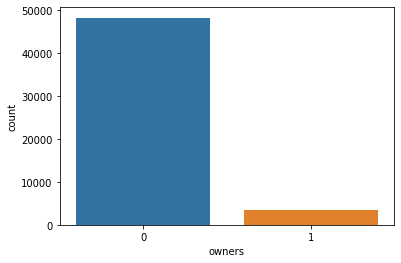

In [ ]:
sns.countplot(x = displayData['owners'])

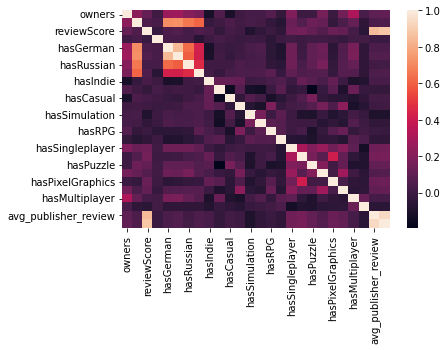

In [ ]:
sns.heatmap(data = displayData.corr())

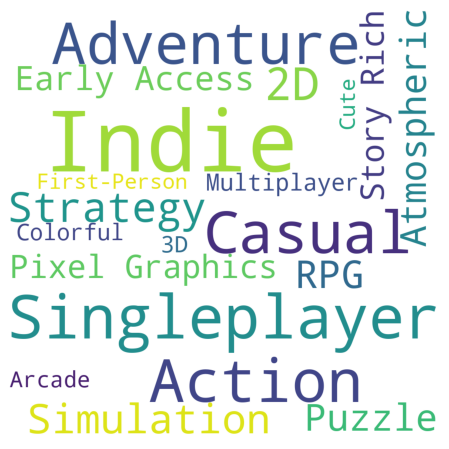

In [ ]:
# word cloud for dictionary of tags, genre, languages

wordcloud_tag = WordCloud(background_color="white",
                          width=1000,
                          height=1000, 
                          max_words=20,
                          relative_scaling=0.5,
                          normalize_plurals=False).generate_from_frequencies(tagDict_vis)

# Display the generated image:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_tag)
plt.axis("off")
plt.show()


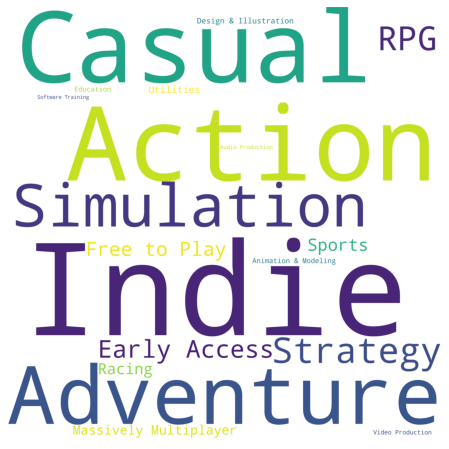

In [ ]:

wordcloud_genre = WordCloud(background_color="white",
                          width=5000,
                          height=5000, 
                          max_words=20,
                          relative_scaling=0.5,
                          normalize_plurals=False).generate_from_frequencies(genreDict_vis)

# Display the generated image:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_genre)
plt.axis("off")
plt.show()


(-0.5, 999.5, 999.5, -0.5)

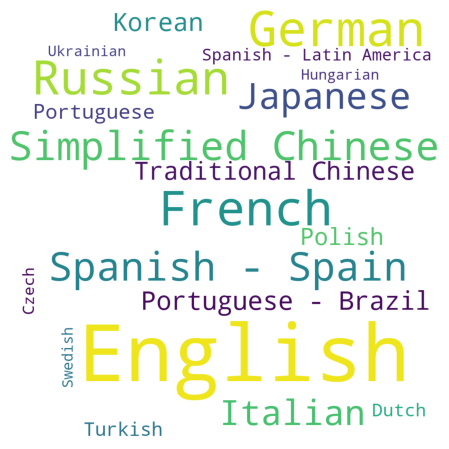

In [ ]:

wordcloud_lang = WordCloud(background_color="white",
                          width=1000,
                          height=1000,                           
                          relative_scaling=0.5,
                          max_words=20,).generate_from_frequencies(languagesDict_vis)

# Display the generated image:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_lang)
plt.axis('off')

# Data Modeling & Hypertuning

We will be trying...
*   Gaussian NB
*   Voting With SVC, NB, AdaBoost
*   ANN

And we will be employing...
*   Standard Scaler
*   Resampling
*   PCA




### First, we will set the data and scale the data

In [ ]:
X= displayData.drop('owners', axis=1)
y= displayData['owners']

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

### Next up is splitting the data and getting a base Gaussian NB benchmark

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB

fin_clf = GaussianNB()
fin_clf.fit(X_train, y_train)
y_pred = fin_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Probability of an Unsuccessful Game: ', fin_clf.class_prior_[0])
print('Probability of a Successful Game: ', fin_clf.class_prior_[1])

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     12060
           1       0.28      0.73      0.41       858

    accuracy                           0.86     12918
   macro avg       0.63      0.80      0.66     12918
weighted avg       0.93      0.86      0.89     12918

Probability of an Unsuccessful Game:  0.9343534694088199
Probability of a Successful Game:  0.06564653059118004


### Resampling and recomparing Gaussian NB

In [ ]:
from sklearn.utils import resample
df_train = pd.DataFrame(data = X_train, columns = displayData.columns[1:])
df_train['owners'] = y_train.values

df_majority = df_train[df_train['owners'] == 0]
df_minority = df_train[df_train['owners'] == 1]

df_majority = resample(df_majority,replace = False, n_samples = 2500)
df_minority = resample(df_minority,replace = True, n_samples = 2500)

df_train_resampled = pd.concat([df_majority,df_minority])

print(df_train_resampled['owners'].value_counts())

0    2500
1    2500
Name: owners, dtype: int64


In [ ]:
X_train = df_train_resampled.drop(labels = 'owners', axis = 1)
y_train = df_train_resampled['owners']
print(X_train.shape)
print(y_train.shape)

(5000, 25)
(5000,)


In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Probability of an Unsuccessful Game: ', clf.class_prior_[0])
print('Probability of a Successful Game: ', clf.class_prior_[1])

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     12060
           1       0.20      0.86      0.32       858

    accuracy                           0.76     12918
   macro avg       0.59      0.81      0.59     12918
weighted avg       0.93      0.76      0.82     12918

Probability of an Unsuccessful Game:  0.5
Probability of a Successful Game:  0.5


C:\Users\augus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


### Utilizing ANN (non-resampled)

In [ ]:
# Can be ran with normal or resampled data, better results with standard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(name = 'steam-spy-ann')
model.add(layers.Dense(units = 6, activation = 'relu', input_dim = 25))
model.add(layers.Dense(units = 6, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))
model.summary()

Model: "steam-spy-ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 156       
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, batch_size = 10, epochs=25)


Epoch 1/25
3876/3876 [==============================] - 9s 2ms/step - loss: 0.1924 - accuracy: 0.9331
Epoch 2/25
3876/3876 [==============================] - 9s 2ms/step - loss: 0.1484 - accuracy: 0.9467
Epoch 3/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1450 - accuracy: 0.9478
Epoch 4/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1430 - accuracy: 0.9480
Epoch 5/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1420 - accuracy: 0.9485
Epoch 6/25
3876/3876 [==============================] - 9s 2ms/step - loss: 0.1412 - accuracy: 0.9482
Epoch 7/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1406 - accuracy: 0.9490
Epoch 8/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1401 - accuracy: 0.9486
Epoch 9/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1396 - accuracy: 0.9486
Epoch 10/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.139

In [ ]:
y_pred = model.predict(X_test)

y_pred = (y_pred> 0.5)*1.0

print(classification_report(y_test, y_pred))

404/404 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12060
           1       0.72      0.31      0.43       858

    accuracy                           0.95     12918
   macro avg       0.84      0.65      0.70     12918
weighted avg       0.94      0.95      0.94     12918



### Voting Classifier with SVC, GaussianNB, and AdaBoost (non-pca, non-resampled)

In [ ]:
# Can be ran with normal or resampled data, better results with standard
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
nb_clf = GaussianNB()
svm_clf = SVC(gamma = 'auto', random_state = 101)
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state = 101), n_estimators=100, random_state=101, learning_rate = 0.5)

voting_clf = VotingClassifier(estimators = [('nb',nb_clf),('svc',svm_clf),('ada',ada_clf)], voting = 'hard')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('svc', SVC(gamma='auto', random_state=101)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                       random_state=101),
                                                 learning_rate=0.5,
                                                 n_estimators=100,
                                                 random_state=101))])

In [ ]:
for clf in (nb_clf, svm_clf, ada_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))
  print(classification_report(y_test, y_pred))

GaussianNB 0.8588016720854621
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     12060
           1       0.28      0.73      0.41       858

    accuracy                           0.86     12918
   macro avg       0.63      0.80      0.66     12918
weighted avg       0.93      0.86      0.89     12918

SVC 0.9470506270320483
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12060
           1       0.75      0.30      0.43       858

    accuracy                           0.95     12918
   macro avg       0.85      0.65      0.70     12918
weighted avg       0.94      0.95      0.94     12918

AdaBoostClassifier 0.94697321566806
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12060
           1       0.67      0.39      0.49       858

    accuracy                           0.95     12918
   macro avg       0.82      0.69      

Our overall model accuracy is sufficent for this problem, but classification of class 1 (succesful games) is below 50%. Lets's try to improve this number.

### Now we will apply PCA

In [ ]:
from sklearn.decomposition import PCA

X= displayData.drop('owners', axis=1)
y= displayData['owners']

sc = StandardScaler()
X = sc.fit_transform(X)

pca = PCA()
X_reduced = pca.fit_transform(X)
X_reduced.shape

(51671, 25)

In [ ]:
df_pca = pd.DataFrame(data = X_reduced, columns = displayData.columns[1:])
df_pca['owners'] = y.values

df_pca.head()

,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,hasIndie,hasAction,hasCasual,...,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay,avg_publisher_review,avg_developer_review,owners
0,4.881351,2.304373,-3.677241,1.368155,0.396189,-0.109071,0.884577,0.888046,-1.608307,1.014381,...,-0.744498,1.082371,1.028151,-0.037026,0.129408,2.549152,0.237051,-0.324421,-0.061303,1
1,4.896225,2.018515,-3.465103,1.840157,-0.034626,-1.337315,0.347363,0.940957,-1.356240,1.314602,...,-0.244032,0.953865,0.968750,-0.194289,0.141609,2.457744,0.089383,-0.322992,-0.049849,1
2,3.312463,3.372833,-1.796882,2.315015,-0.548592,-1.263538,0.230873,0.806571,-1.524659,1.269935,...,-0.591833,1.227039,0.319269,-0.189376,0.174004,0.608718,0.147803,-0.073576,0.041953,1
3,1.130783,1.737772,-1.112695,2.698051,-0.918698,-0.214592,0.403951,0.798713,-0.025139,-0.460143,...,1.130623,-0.860731,0.686832,-0.681246,-1.045245,0.286301,-0.195550,-0.101908,0.190752,1
4,4.757001,1.866624,-3.492121,1.839735,-0.071418,-1.331985,0.388826,0.917231,-1.337741,1.308207,...,-0.232504,0.932542,0.955852,-0.190502,0.174592,2.120831,-0.099062,-0.253595,-0.120150,1


In [ ]:
df_scree = pd.DataFrame(data = pca.explained_variance_ratio_,columns = ['Explained Variance Ratio'], index = ['PC{}'.format(i) for i in range (1,26)])
df_scree.head(25)

,Explained Variance Ratio
PC1,0.149907
PC2,0.118621
PC3,0.072626
PC4,0.060578
PC5,0.053687
PC6,0.052328
PC7,0.050280
PC8,0.044254
PC9,0.039852
PC10,0.039246


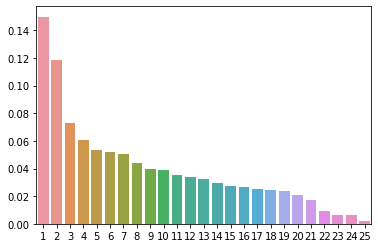

In [ ]:
height = []
for i in df_scree.values:
  height.append(i[0])
sns.barplot(x = np.arange(pca.n_components_)+1, y = height)

In [ ]:
pca = PCA(n_components = 20)
X = pca.fit_transform(X)

#### Now we split the data and compare our Gaussian benchmark

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Probability of an Unsuccessful Game: ', clf.class_prior_[0])
print('Probability of a Successful Game: ', clf.class_prior_[1])

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12060
           1       0.52      0.46      0.49       858

    accuracy                           0.94     12918
   macro avg       0.74      0.71      0.73     12918
weighted avg       0.93      0.94      0.93     12918

Probability of an Unsuccessful Game:  0.9343534694088199
Probability of a Successful Game:  0.06564653059118004


### Resampling the training dataset using PCA findings

In [ ]:
from sklearn.utils import resample
df_train = pd.DataFrame(data = X_train)
df_train['owners'] = y_train.values

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,owners
0,-0.328762,0.128629,1.789850,1.270423,3.114830,-1.037357,0.484285,0.611256,0.606619,-0.332516,...,0.293382,-0.748071,-0.390306,-0.038533,0.123613,0.039121,-0.134291,-0.317545,0.379556,0
1,-0.836162,-0.970245,0.442074,1.516795,-1.548529,1.472842,-0.781176,-1.302536,0.416572,-0.965278,...,-1.025383,-0.713162,0.549924,1.288143,-1.909462,0.978464,-0.315108,0.921130,-0.850773,0
2,-0.799678,-2.019778,-1.459014,-1.330270,-0.257442,-0.408768,-1.252398,0.088172,0.024141,-0.074676,...,-0.186681,0.319326,-0.671854,-0.350161,0.106835,0.898131,0.014838,-0.460103,-0.017994,0
3,4.213174,1.527181,-1.399135,-0.671266,1.738028,0.451610,1.188693,-0.299601,-1.686475,1.730846,...,-0.766448,0.733618,-0.231373,0.988402,0.728697,-0.193448,0.269665,-0.613052,-1.100015,1
4,0.362570,-2.663696,0.361461,-2.111605,-1.897942,-0.781461,1.073070,0.305482,0.104350,0.189379,...,0.605138,1.334274,-0.571964,-0.462389,1.121458,-0.634496,-0.573972,1.482898,1.100887,0


In [ ]:
df_majority = df_train[df_train['owners'] == 0]
df_minority = df_train[df_train['owners'] == 1]

df_majority = resample(df_majority,replace = False, n_samples = 2500)
df_minority = resample(df_minority,replace = True, n_samples = 2500)

df_train_resampled = pd.concat([df_majority,df_minority])

print(df_train_resampled['owners'].value_counts())

0    2500
1    2500
Name: owners, dtype: int64


In [ ]:
X_train = df_train_resampled.drop(labels = 'owners', axis = 1)
y_train = df_train_resampled['owners']
print(X_train.shape)
print(y_train.shape)

(5000, 20)
(5000,)


#### Gaussian NB for our resampled data

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Probability of an Unsuccessful Game: ', clf.class_prior_[0])
print('Probability of a Successful Game: ', clf.class_prior_[1])

              precision    recall  f1-score   support

           0       0.98      0.82      0.90     12060
           1       0.25      0.81      0.38       858

    accuracy                           0.82     12918
   macro avg       0.62      0.82      0.64     12918
weighted avg       0.93      0.82      0.86     12918

Probability of an Unsuccessful Game:  0.5
Probability of a Successful Game:  0.5


### ANN with PCA (non-resampled)

In [ ]:
 # Can be ran with normal or resampled data, better results with standard
model = keras.Sequential(name = 'steam-spy-ann')
model.add(layers.Dense(units = 6, activation = 'relu', input_dim = 20))
model.add(layers.Dense(units = 6, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))
model.summary()


Model: "steam-spy-ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 126       
                                                                 
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, batch_size = 10, epochs=25)


Epoch 1/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1938 - accuracy: 0.9325
Epoch 2/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.1496 - accuracy: 0.9447
Epoch 3/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.1451 - accuracy: 0.9472
Epoch 4/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.1430 - accuracy: 0.9480
Epoch 5/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.1421 - accuracy: 0.9483
Epoch 6/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.1415 - accuracy: 0.9482
Epoch 7/25
3876/3876 [==============================] - 11s 3ms/step - loss: 0.1410 - accuracy: 0.9482
Epoch 8/25
3876/3876 [==============================] - 8s 2ms/step - loss: 0.1406 - accuracy: 0.9486
Epoch 9/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.1406 - accuracy: 0.9483
Epoch 10/25
3876/3876 [==============================] - 7s 2ms/step - loss: 0.14

In [ ]:
y_pred = model.predict(X_test)

y_pred = (y_pred> 0.5)*1.0

print(classification_report(y_test, y_pred))

404/404 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12060
           1       0.69      0.37      0.48       858

    accuracy                           0.95     12918
   macro avg       0.83      0.68      0.73     12918
weighted avg       0.94      0.95      0.94     12918



### Voting Classifier with SVC, GaussianNB, and AdaBoost (PCA, non-resampled)

In [ ]:
# Can be ran with normal or resampled data, better results with standard
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
nb_clf = GaussianNB()
svm_clf = SVC(gamma = 'auto', random_state = 101)
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state = 101), n_estimators=100, random_state=101, learning_rate = 0.5)

voting_clf = VotingClassifier(estimators = [('nb',nb_clf),('svc',svm_clf),('ada',ada_clf)], voting = 'hard')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('svc', SVC(gamma='auto', random_state=101)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                       random_state=101),
                                                 learning_rate=0.5,
                                                 n_estimators=100,
                                                 random_state=101))])

In [ ]:
for clf in (nb_clf, svm_clf, ada_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))
  print(classification_report(y_test, y_pred))

GaussianNB 0.9355937451617897
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12060
           1       0.52      0.46      0.49       858

    accuracy                           0.94     12918
   macro avg       0.74      0.71      0.73     12918
weighted avg       0.93      0.94      0.93     12918

SVC 0.9467409815760953
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12060
           1       0.75      0.30      0.43       858

    accuracy                           0.95     12918
   macro avg       0.85      0.65      0.70     12918
weighted avg       0.94      0.95      0.94     12918

AdaBoostClassifier 0.9448056974763895
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12060
           1       0.68      0.31      0.43       858

    accuracy                           0.94     12918
   macro avg       0.82      0.65    

Our overall model accuracy is sufficent for this problem, but classification of class 1 (succesful games) is below 50%. Lets's try to improve this number.

### SMOTE Resampling

### More Advanced ANN

In [ ]:
model = keras.Sequential(name = 'steam-spy-ann2')
model.add(layers.Dense(units = 36, activation = 'relu', input_dim = 25))
model.add(layers.Dense(units = 6, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))
model.summary()

Model: "steam-spy-ann2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 36)                936       
                                                                 
 dense_4 (Dense)             (None, 6)                 222       
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,165
Trainable params: 1,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, batch_size = 32, epochs=25)


Epoch 1/25
1212/1212 [==============================] - 4s 2ms/step - loss: 0.1863 - accuracy: 0.9399
Epoch 2/25
1212/1212 [==============================] - 3s 2ms/step - loss: 0.1520 - accuracy: 0.9447
Epoch 3/25
1212/1212 [==============================] - 2s 2ms/step - loss: 0.1484 - accuracy: 0.9456
Epoch 4/25
1212/1212 [==============================] - 3s 2ms/step - loss: 0.1462 - accuracy: 0.9452
Epoch 5/25
1212/1212 [==============================] - 2s 2ms/step - loss: 0.1447 - accuracy: 0.9456
Epoch 6/25
1212/1212 [==============================] - 3s 2ms/step - loss: 0.1435 - accuracy: 0.9459
Epoch 7/25
1212/1212 [==============================] - 2s 2ms/step - loss: 0.1419 - accuracy: 0.9468
Epoch 8/25
1212/1212 [==============================] - 2s 2ms/step - loss: 0.1403 - accuracy: 0.9475
Epoch 9/25
1212/1212 [==============================] - 2s 2ms/step - loss: 0.1402 - accuracy: 0.9481
Epoch 10/25
1212/1212 [==============================] - 3s 2ms/step - loss: 0.138

In [ ]:
y_pred = model.predict(X_test)

y_pred = (y_pred> 0.5)*1.0

print(classification_report(y_test, y_pred))

404/404 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12060
           1       0.76      0.31      0.45       858

    accuracy                           0.95     12918
   macro avg       0.86      0.65      0.71     12918
weighted avg       0.94      0.95      0.94     12918



### More Advanced ANN with Resampled Data

In [ ]:
from sklearn.utils import resample
df_train = pd.DataFrame(data = X_train, columns = displayData.columns[1:])
df_train['owners'] = y_train.values

df_majority = df_train[df_train['owners'] == 0]
df_minority = df_train[df_train['owners'] == 1]

df_majority = resample(df_majority,replace = False, n_samples = 2500)
df_minority = resample(df_minority,replace = True, n_samples = 2500)

df_train_resampled = pd.concat([df_majority,df_minority])

print(df_train_resampled['owners'].value_counts())

0    2500
1    2500
Name: owners, dtype: int64


In [ ]:
X_train = df_train_resampled.drop(labels = 'owners', axis = 1)
y_train = df_train_resampled['owners']
print(X_train.shape)
print(y_train.shape)

(5000, 25)
(5000,)


In [ ]:
model = keras.Sequential(name = 'steam-spy-ann2')
model.add(layers.Dense(units = 36, activation = 'relu', input_dim = 25))
model.add(layers.Dense(units = 6, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))
model.summary()

Model: "steam-spy-ann2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 36)                936       
                                                                 
 dense_7 (Dense)             (None, 6)                 222       
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,165
Trainable params: 1,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, batch_size = 32, epochs=25)


Epoch 1/25
157/157 [==============================] - 1s 2ms/step - loss: 0.6084 - accuracy: 0.6804
Epoch 2/25
157/157 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 0.8038
Epoch 3/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3972 - accuracy: 0.8236
Epoch 4/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3746 - accuracy: 0.8362
Epoch 5/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8418
Epoch 6/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8456
Epoch 7/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3583 - accuracy: 0.8422
Epoch 8/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3470 - accuracy: 0.8516
Epoch 9/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3464 - accuracy: 0.8524
Epoch 10/25
157/157 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.8546

In [ ]:
y_pred = model.predict(X_test)

y_pred = (y_pred> 0.5)*1.0

print(classification_report(y_test, y_pred))

404/404 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     12060
           1       0.27      0.83      0.40       858

    accuracy                           0.84     12918
   macro avg       0.63      0.83      0.65     12918
weighted avg       0.94      0.84      0.87     12918



### Model Adjustment for Low Quality Games

Because the majority of the games in this dataset are games of quantity not quality, we will look to drop these games so they do not negatively affect our model.

We will use a previous copy of the same dataset and perform the same data preprocessing up to the point of qualifying owners. We will drop games with owners below 20,000 predicted owners as this data is most likely inaccurate.

In [ ]:
steamspy_copy.drop(steamspy_copy.loc[steamspy_copy['owners'] == '0 .. 20,000'].index, inplace=True)

In [ ]:
steamspy_copy['positive'] = pd.to_numeric(steamspy_copy['positive'])
steamspy_copy['negative'] = pd.to_numeric(steamspy_copy['negative'])
steamspy_copy['owners'] = (steamspy_copy['positive']+steamspy_copy['negative'])*50
steamspy_copy['owners'] = steamspy_copy['owners'].apply(ownersMorph)
grouped_pub = steamspy_copy.groupby('publisher')['reviewScore'].mean()
grouped_dev = steamspy_copy.groupby('developer')['reviewScore'].mean()
steamspy_copy['avg_publisher_review'] = steamspy_copy['publisher'].apply(publisher_review_add)
steamspy_copy['avg_developer_review'] = steamspy_copy['developer'].apply(developer_review_add)
steamspy_copy.drop(labels = ['positive','negative'], axis = 1, inplace = True)
steamspy_copy.dropna(inplace = True)
displayData_shovel = steamspy_copy.drop(labels = ['developer','publisher'], axis = 1)
displayData_shovel

,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,hasIndie,hasAction,...,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay,avg_publisher_review,avg_developer_review
570,1,28,0.833064,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.901220,0.881248
730,1,28,0.882450,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.901220,0.882450
578080,1,17,0.561891,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.619784,0.619784
1063730,1,8,0.677692,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0.618010,0.677692
440,1,26,0.935460,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.901220,0.881248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816490,0,15,0.889267,1,1,1,1,1,1,0,...,1,0,1,1,0,0,0,0,0.889267,0.889267
1119600,0,3,0.809668,1,0,0,1,0,0,0,...,0,1,0,1,0,1,0,0,0.619262,0.809668
994910,0,4,0.922844,1,0,0,1,1,0,0,...,0,1,0,0,0,0,1,1,0.922844,0.922844
611790,1,6,0.884282,1,0,1,1,1,1,0,...,1,0,1,0,0,1,0,0,0.884282,0.884282


Now we will use some of the top models that we have already looked at to assess the new dataset.

In [ ]:
X= displayData_shovel.drop('owners', axis=1)
y= displayData_shovel['owners']

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [ ]:
model = keras.Sequential(name = 'steam-spy-ann')
model.add(layers.Dense(units = 6, activation = 'relu', input_dim = 25))
model.add(layers.Dense(units = 6, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(X_train, y_train, batch_size = 10, epochs=25)


Epoch 1/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.4185 - accuracy: 0.8005
Epoch 2/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3494 - accuracy: 0.8443
Epoch 3/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3376 - accuracy: 0.8507
Epoch 4/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3333 - accuracy: 0.8521
Epoch 5/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3314 - accuracy: 0.8537
Epoch 6/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3296 - accuracy: 0.8554
Epoch 7/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3284 - accuracy: 0.8550
Epoch 8/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3272 - accuracy: 0.8538
Epoch 9/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.3270 - accuracy: 0.8555
Epoch 10/25
1226/1226 [==============================] - 2s 2ms/step - loss: 0.325

In [ ]:
y_pred = model.predict(X_test)

y_pred = (y_pred> 0.5)*1.0

print(classification_report(y_test, y_pred))

128/128 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3240
           1       0.67      0.49      0.56       845

    accuracy                           0.84      4085
   macro avg       0.77      0.71      0.73      4085
weighted avg       0.83      0.84      0.83      4085



In [ ]:
pca = PCA(n_components = 20)
X = pca.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('Probability of an Unsuccessful Game: ', clf.class_prior_[0])
print('Probability of a Successful Game: ', clf.class_prior_[1])

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3240
           1       0.67      0.47      0.55       845

    accuracy                           0.84      4085
   macro avg       0.77      0.70      0.73      4085
weighted avg       0.83      0.84      0.83      4085

Probability of an Unsuccessful Game:  0.7913980249734759
Probability of a Successful Game:  0.2086019750265241


In [ ]:
#resample
df_train = pd.DataFrame(data = X_train)
df_train['owners'] = y_train.values

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,owners
0,-1.683257,-0.653427,-0.806766,-0.596131,0.021304,-1.114226,0.308186,0.131683,1.353237,-0.995557,...,0.016481,-0.747894,-0.518421,-0.365834,0.153392,-0.077612,0.380802,0.276620,0.057535,0
1,-1.845012,0.182359,-1.215158,-0.437968,1.231484,2.602616,2.041875,-1.021721,-2.065109,1.109993,...,-1.009361,1.029433,0.648141,-0.520224,-0.601049,0.370360,-0.082096,-1.328322,-0.178402,0
2,1.617648,2.737374,-1.855400,-1.070821,1.089305,-0.441192,1.557410,-0.610999,0.435828,0.258324,...,1.840329,1.646757,-0.553183,0.401882,0.566984,-0.941239,-0.196911,0.151133,-0.043886,1
3,-1.606421,1.909649,0.539922,-0.540942,-0.102691,0.135645,0.290459,-0.453173,1.113362,-0.918354,...,1.244096,-0.512438,1.676677,0.040625,-0.332926,-0.519156,-0.556456,0.835645,-0.084878,0
4,-2.488837,1.036425,-0.933541,0.248627,0.969356,0.352866,1.650176,-2.469229,1.232337,-0.231631,...,2.252417,0.261535,-0.283576,-0.387099,-0.107621,0.096226,0.782388,0.749876,0.220336,0


In [ ]:
df_majority = df_train[df_train['owners'] == 0]
df_minority = df_train[df_train['owners'] == 1]

df_majority = resample(df_majority,replace = False, n_samples = 2500)
df_minority = resample(df_minority,replace = True, n_samples = 2500)

df_train_resampled = pd.concat([df_majority,df_minority])

print(df_train_resampled['owners'].value_counts())

0    2500
1    2500
Name: owners, dtype: int64


In [ ]:
for clf in (nb_clf, svm_clf, ada_clf, voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))
  print(classification_report(y_test, y_pred))

GaussianNB 0.8416156670746634
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3240
           1       0.67      0.47      0.55       845

    accuracy                           0.84      4085
   macro avg       0.77      0.70      0.73      4085
weighted avg       0.83      0.84      0.83      4085

SVC 0.8533659730722154
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3240
           1       0.72      0.47      0.57       845

    accuracy                           0.85      4085
   macro avg       0.80      0.71      0.74      4085
weighted avg       0.84      0.85      0.84      4085

AdaBoostClassifier 0.8443084455324358
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3240
           1       0.68      0.47      0.55       845

    accuracy                           0.84      4085
   macro avg       0.78      0.71    

# New Try Resampling with SMOTE

Here we will use the SMOTE library from imblearn in order to get a better 

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X= displayData.drop('owners', axis=1)
y= displayData['owners']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [ ]:
sm = SMOTE(random_state=101)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_res.value_counts()

In [ ]:
for clf in (nb_clf, svm_clf, ada_clf, voting_clf):
  clf.fit(X_train_res,y_train_res)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))
  print(classification_report(y_test, y_pred))

Smote is unable to give our resampled accuracy the boost it needs to rival or exceed the unaltered data.

# Application

Here we will use our findings in a simple application which predicts the success of a game given the user's details

We will use the model with the best overall accuracy to build our application. First we'll select one successful and one non-successful game to test the application.

In [ ]:
displayData[displayData['owners']==1]

,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,hasIndie,hasAction,...,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay,avg_publisher_review,avg_developer_review
570,1,28,0.833064,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.891699,0.871754
730,1,28,0.882450,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.891699,0.882450
578080,1,17,0.561891,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.619784,0.619784
1063730,1,8,0.677692,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0.618010,0.677692
440,1,26,0.935460,1,1,1,1,1,0,1,...,0,0,0,0,0,0,1,1,0.891699,0.871754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044620,1,4,0.983644,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0.980352,0.984982
1036890,1,11,0.606624,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0.850105,0.822260
443110,1,4,0.686773,1,1,1,0,0,1,1,...,0,0,0,0,0,0,1,1,0.792985,0.829034
723390,1,8,0.413974,1,1,1,1,1,0,1,...,1,0,0,1,0,0,0,0,0.413974,0.413974


In [ ]:
displayData[displayData['owners']==0]

,owners,languages,reviewScore,hasEnglish,hasGerman,hasFrench,hasRussian,hasChinese,hasIndie,hasAction,...,hasSingleplayer,has2D,hasPuzzle,hasAtmospheric,hasPixelGraphics,hasStoryRich,hasMultiplayer,isFreeToPlay,avg_publisher_review,avg_developer_review
417910,0,7,0.577313,1,1,0,1,1,0,1,...,0,0,0,0,0,0,1,0,0.577313,0.577313
1627140,0,5,0.000000,1,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0.761734,0.000000
9340,0,1,0.917660,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0.853449,0.934937
319830,0,1,0.767364,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0.511595,0.767364
510840,0,18,0.694079,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0.694079,0.694079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406980,0,1,0.500000,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0.527778,0.527778
1209610,0,1,1.000000,1,0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1.000000,1.000000
1503000,0,1,1.000000,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1.000000,1.000000
1506770,0,1,0.416667,1,0,0,0,0,1,1,...,1,0,0,1,1,0,0,0,0.416667,0.416667


In [ ]:
app_data_ex1 = displayData.drop('owners', axis=1).iloc[730,:]

In [ ]:
app_data_ex0 = displayData.drop('owners', axis=1).iloc[9340,:]

Now let's bulid the application and test these games.

In [ ]:
def model_app(app_data):
    '''
    Arguments: 
    1) df_app: DataFrame with test data to be evaluated by the trained model
    
    Returns: 
    The prediction is returned as an array containing binary value 0 being Unsuccessful 
    and 1 being Successful. This is then easily displayed to the user through text. 
    '''
    #app_data = 
    app_pred = fin_clf.predict(app_data.values.reshape(1,-1))[0]
    
    if(app_pred == 1):
        print('Based on your information this game will be successful.')
    else:
        print('Based on your information this game NOT will be successful.')


In [ ]:
model_app(app_data_ex1)

Based on your information this game will be successful.


In [ ]:
model_app(app_data_ex0)

Based on your information this game NOT will be successful.


As you can see our application predicted correctly. Now we'll simulate being a developer and make a 'fake' game, we will be using existing review score data and making up the other features based on the type of game we want to create.

In [ ]:
fake_game_arr = pd.Series(np.array([6, 0.686773, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0.792985, 0.829034]))
fake_game_arr

0     6.000000
1     0.686773
2     1.000000
3     1.000000
4     0.000000
5     1.000000
6     1.000000
7     0.000000
8     1.000000
9     0.000000
10    1.000000
11    0.000000
12    0.000000
13    0.000000
14    1.000000
15    1.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    1.000000
21    0.000000
22    1.000000
23    0.792985
24    0.829034
dtype: float64

In [ ]:
model_app(fake_game_arr)

Based on your information this game will be successful.


# Findings and Future Work

From this work we find resampling to consistently decrease the predictive abilities of our models. 

We also find PCA to situationally change the accuracy of our models. 

The overall accuracy is good however like other spam/ham problems, our goal is to classify the minority class which we are only able to do with medicore results using these models.

For future work, we would like to explore more advanced ANN models and try to understand why resampling decreases the abilities of our models.

Ultimately, with the data we have, it is difficult to predict the success of a game.